In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import dateutil.parser as parser
from datetime import datetime, date, timedelta
import torch
import skorch
import scipy
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
from skorch.helper import DataFrameTransformer
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from skorch.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from skorch import NeuralNetRegressor
import pickle

def identity_tokenizer(text):
    return text
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)

def profitestimator(model_predictions, actual_results, relevant_dates):
    unique = relevant_dates.unique()
    profit = 0
    bullorbearcount = 0
    invested = 0
    for uni in unique:
        predsum = 0
        reala = 0
        for i, (pred, real, date) in enumerate(zip(model_predictions, actual_results, relevant_dates)):
            if date == uni:
                predsum += pred
                reala = real
        invested += abs(predsum)
        daychange = predsum * reala
        profit += daychange
        if predsum > 0 and reala > 0:
            bullorbearcount += 1
        elif predsum < 0 and reala < 0:
            bullorbearcount += 1
    print("Profit:", profit)
    print("Accuracy:", (bullorbearcount/len(unique)))
    print("Sum Invested:", invested)
    print("Profitability:", (profit/invested))

# Please ignore the below cells, they were for additional preprocessing and do not need to be run again

In [54]:
# Opening JSON file
f = open('twitter_aapl_1.json',)
  
# returns JSON object as 
# a dictionary
aapl = json.load(f)

f.close()

In [55]:
flataapl  = [val for sublist in aapl for val in sublist]

In [56]:
print(flataapl[0])

{'created_at': '2021-05-11T10:18:35.000Z', 'id': '1392061565185236994', 'text': 'RT @Nicochan33: Apple Execs Chose to Keep a Hack of 128 Million iPhones Quiet https://t.co/waR9tgHKCA #tech #feedly #apple #iphone #cyberse…'}


In [57]:
df = pd.DataFrame(flataapl)
df

,created_at,id,text,withheld
0,2021-05-11T10:18:35.000Z,1392061565185236994,RT @Nicochan33: Apple Execs Chose to Keep a Ha...,NaN
1,2021-05-11T10:18:30.000Z,1392061546751217671,"RT @RoseLoveStyle: House of the Dragon, the pr...",NaN
2,2021-05-11T10:18:25.000Z,1392061526614360066,RT @gtorges: Ich habe jetzt einiges an Materia...,NaN
3,2021-05-11T10:17:54.000Z,1392061393415909376,RT @iTech911: Future versions of #Apple's CarK...,NaN
4,2021-05-11T10:17:48.000Z,1392061371886485506,発売日に予約してようやく届いた🤗\n#Apple #airtag #ケースは純正じゃない #...,NaN
...,...,...,...,...
517126,2021-02-18T07:25:14.000Z,1362302135333969929,RT @mobitrade_: Original Apple Airpods Pro New...,NaN
517127,2021-02-18T07:25:08.000Z,1362302111027929089,#ios #Apple #swiftui \nSwiftUI 2.0 Complex UI ...,NaN
517128,2021-02-18T07:25:06.000Z,1362302102404542467,Sommige appels worden te snel slecht.\n\nhttps...,NaN
517129,2021-02-18T07:24:56.000Z,1362302061589708805,#apple #kia #StockMarkets https://t.co/ccRBBAKDtd,NaN


In [58]:
y = df['withheld'].dropna()
y

152369    {'copyright': False, 'country_codes': ['IN']}
257375    {'copyright': False, 'country_codes': ['IN']}
269997    {'copyright': False, 'country_codes': ['IN']}
315545    {'copyright': False, 'country_codes': ['RU']}
315578    {'copyright': False, 'country_codes': ['RU']}
343775    {'copyright': False, 'country_codes': ['IN']}
473481    {'copyright': False, 'country_codes': ['RU']}
473719    {'copyright': False, 'country_codes': ['RU']}
489545    {'copyright': False, 'country_codes': ['IN']}
509238    {'copyright': False, 'country_codes': ['IN']}
Name: withheld, dtype: object

In [59]:
df1 = df.drop('withheld',axis=1)
df1['created_at'] = df1['created_at'].map(lambda x: str(x)[:-5])
df1

,created_at,id,text
0,2021-05-11T10:18:35,1392061565185236994,RT @Nicochan33: Apple Execs Chose to Keep a Ha...
1,2021-05-11T10:18:30,1392061546751217671,"RT @RoseLoveStyle: House of the Dragon, the pr..."
2,2021-05-11T10:18:25,1392061526614360066,RT @gtorges: Ich habe jetzt einiges an Materia...
3,2021-05-11T10:17:54,1392061393415909376,RT @iTech911: Future versions of #Apple's CarK...
4,2021-05-11T10:17:48,1392061371886485506,発売日に予約してようやく届いた🤗\n#Apple #airtag #ケースは純正じゃない #...
...,...,...,...
517126,2021-02-18T07:25:14,1362302135333969929,RT @mobitrade_: Original Apple Airpods Pro New...
517127,2021-02-18T07:25:08,1362302111027929089,#ios #Apple #swiftui \nSwiftUI 2.0 Complex UI ...
517128,2021-02-18T07:25:06,1362302102404542467,Sommige appels worden te snel slecht.\n\nhttps...
517129,2021-02-18T07:24:56,1362302061589708805,#apple #kia #StockMarkets https://t.co/ccRBBAKDtd


In [60]:
df1.to_csv("twitter_aapl_1_clean.csv", index = False)

In [2]:
df1 = pd.read_csv("twitter_aapl_1_clean.csv")
# Only including this step for now, basically removes the time component, leaving only date
df1['created_at'] = df1['created_at'].map(lambda x: str(x)[:-9])
df1 = df1.rename(columns={"created_at" : "Date"})
df1

,Date,id,text
0,2021-05-11,1392061565185236994,RT @Nicochan33: Apple Execs Chose to Keep a Ha...
1,2021-05-11,1392061546751217671,"RT @RoseLoveStyle: House of the Dragon, the pr..."
2,2021-05-11,1392061526614360066,RT @gtorges: Ich habe jetzt einiges an Materia...
3,2021-05-11,1392061393415909376,RT @iTech911: Future versions of #Apple's CarK...
4,2021-05-11,1392061371886485506,発売日に予約してようやく届いた🤗\n#Apple #airtag #ケースは純正じゃない #...
...,...,...,...
517126,2021-02-18,1362302135333969929,RT @mobitrade_: Original Apple Airpods Pro New...
517127,2021-02-18,1362302111027929089,#ios #Apple #swiftui \nSwiftUI 2.0 Complex UI ...
517128,2021-02-18,1362302102404542467,Sommige appels worden te snel slecht.\n\nhttps...
517129,2021-02-18,1362302061589708805,#apple #kia #StockMarkets https://t.co/ccRBBAKDtd


In [3]:
# adapted from https://www.30secondsofcode.org/python/s/is-weekend
def if_weekend(d = datetime.today()):
    if d.weekday() == 5:
        da = d + timedelta(days=2)
        return da
    elif d.weekday() == 6:
        da = d + timedelta(days=1)
        return da
    elif d == date(2021,4,2):
        return date(2021,4,5)
    else:
        return d
print(if_weekend(date(2021,6,14)))
print(type(date(2021,6,14)))

2021-06-14
<class 'datetime.date'>


In [4]:
df1['Date']= pd.to_datetime(df1['Date'])
df1['usedate'] = df1['Date'].map(lambda x: if_weekend(x))
df1

,Date,id,text,usedate
0,2021-05-11,1392061565185236994,RT @Nicochan33: Apple Execs Chose to Keep a Ha...,2021-05-11
1,2021-05-11,1392061546751217671,"RT @RoseLoveStyle: House of the Dragon, the pr...",2021-05-11
2,2021-05-11,1392061526614360066,RT @gtorges: Ich habe jetzt einiges an Materia...,2021-05-11
3,2021-05-11,1392061393415909376,RT @iTech911: Future versions of #Apple's CarK...,2021-05-11
4,2021-05-11,1392061371886485506,発売日に予約してようやく届いた🤗\n#Apple #airtag #ケースは純正じゃない #...,2021-05-11
...,...,...,...,...
517126,2021-02-18,1362302135333969929,RT @mobitrade_: Original Apple Airpods Pro New...,2021-02-18
517127,2021-02-18,1362302111027929089,#ios #Apple #swiftui \nSwiftUI 2.0 Complex UI ...,2021-02-18
517128,2021-02-18,1362302102404542467,Sommige appels worden te snel slecht.\n\nhttps...,2021-02-18
517129,2021-02-18,1362302061589708805,#apple #kia #StockMarkets https://t.co/ccRBBAKDtd,2021-02-18


In [5]:
price = pd.read_csv("aapl2.csv")
price['Date'] = price['Date'].map(lambda x: parser.parse(x).isoformat())
# Only including this step for now, basically removes the time component, leaving only date
price['Date'] = price['Date'].map(lambda x: str(x)[:-9])
price['Date']= pd.to_datetime(price['Date'])
# Change me if looking to change examination scope
price = price.rename(columns={"Date" : "usedate"})
price

,usedate,Close/Last,Volume,Open,High,Low,Change
0,2021-05-11,125.9100,126142800,123.5000,126.2700,122.7700,2.4100
1,2021-05-10,126.8500,88071230,129.4100,129.5400,126.8100,-2.5600
2,2021-05-07,130.2100,78973270,130.8500,131.2582,129.4750,-0.6400
3,2021-05-06,129.7400,78128330,127.8900,129.7500,127.1300,1.8500
4,2021-05-05,128.1000,84000900,129.2000,130.4500,127.9700,-1.1000
...,...,...,...,...,...,...,...
247,2020-05-18,78.7400,135372520,78.2925,79.1250,77.5810,0.4475
248,2020-05-15,76.9275,166348360,75.0875,76.9750,75.0525,1.8400
249,2020-05-14,77.3850,158929080,76.1275,77.4475,75.3825,1.2575
250,2020-05-13,76.9125,200622560,78.0375,78.9875,75.8025,-1.1250


In [6]:
merged = pd.merge(df1, price, how='left', on='usedate')
merged

,Date,id,text,usedate,Close/Last,Volume,Open,High,Low,Change
0,2021-05-11,1392061565185236994,RT @Nicochan33: Apple Execs Chose to Keep a Ha...,2021-05-11,125.91,126142800,123.5,126.270,122.77,2.41
1,2021-05-11,1392061546751217671,"RT @RoseLoveStyle: House of the Dragon, the pr...",2021-05-11,125.91,126142800,123.5,126.270,122.77,2.41
2,2021-05-11,1392061526614360066,RT @gtorges: Ich habe jetzt einiges an Materia...,2021-05-11,125.91,126142800,123.5,126.270,122.77,2.41
3,2021-05-11,1392061393415909376,RT @iTech911: Future versions of #Apple's CarK...,2021-05-11,125.91,126142800,123.5,126.270,122.77,2.41
4,2021-05-11,1392061371886485506,発売日に予約してようやく届いた🤗\n#Apple #airtag #ケースは純正じゃない #...,2021-05-11,125.91,126142800,123.5,126.270,122.77,2.41
...,...,...,...,...,...,...,...,...,...,...
517126,2021-02-18,1362302135333969929,RT @mobitrade_: Original Apple Airpods Pro New...,2021-02-18,129.71,96856750,129.2,129.995,127.41,0.51
517127,2021-02-18,1362302111027929089,#ios #Apple #swiftui \nSwiftUI 2.0 Complex UI ...,2021-02-18,129.71,96856750,129.2,129.995,127.41,0.51
517128,2021-02-18,1362302102404542467,Sommige appels worden te snel slecht.\n\nhttps...,2021-02-18,129.71,96856750,129.2,129.995,127.41,0.51
517129,2021-02-18,1362302061589708805,#apple #kia #StockMarkets https://t.co/ccRBBAKDtd,2021-02-18,129.71,96856750,129.2,129.995,127.41,0.51


In [7]:
merged.isna().sum()

Date          0
id            0
text          0
usedate       0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
Change        0
dtype: int64

In [24]:
# merged.to_csv("merged.csv", index = False)

# Start Here

In [3]:
merged = pd.read_csv('mergedfull.csv')
from sklearn.model_selection import train_test_split  
mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# mergedsmall.to_csv("mergedsmall.csv", index = False)
mergedsmall = pd.read_csv('mergedsmall.csv')
merged = mergedsmall
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
print(all_tweets)
all_tweets = all_tweets.to_list()
print(all_tweets[0])
print(all_tweets[1])
print(all_tweets[2])

0         2020 is almost ended\n\nBRAND NEW SEALED FACTO...
1         If you feel like Apple has no love for you by ...
2         📢NEW RIP IS LIVE📢\n\n2W1B 051 - iPhone, Capita...
3         #Apple has introduced a new #macOS version of ...
4         Good Deal😍 #MacBookPro #AppleEvent #Apple\n\nN...
                                ...                        
508177    Foreign Exchange History: How it All Started?\...
508178    Tropicana Apple Juice, 10 oz., 24 Count\n\nSta...
508179    "emotional conclusion to a dazzling series!"\n...
508180    3％超上昇した銘柄\n4434  サーバーワークス\n4625  アトミクス\n6777  ...
508181    EP 42: @seanmagers and @keithrconrad discuss t...
Name: text, Length: 508182, dtype: object
2020 is almost ended

BRAND NEW SEALED FACTORY UNLOCKED iPHONE12 Mini to one LUCKY FOLLOWER.

Keep Following &amp; Retweeting.

#iTech911 #iBuy #iSell #iSwap #iFix #APPLE 

0262666226 💬 📞 https://t.co/3vOZQIN8yz
If you feel like Apple has no love for you by not delivering the Heart Month Challeng

In [3]:
print(len(all_tweets))

508182


In [4]:
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [5]:
# https://python.gotrained.com/scraping-tweets-sentiment-analysis/
# Basic cleaning of text before TF-IDF; this process will be improved later
# for tweet in all_tweets:
#     # Remove all the special characters
#     processed_tweet = re.sub(r'\W', ' ', tweet)
 
#     # remove all single characters
#     processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
#     # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
#     # Substituting multiple spaces with single space
#     processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
#     # Removing prefixed 'b'
#     processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    
#     #removing common pronouns and prepositions
#     processed_tweet = re.sub(r'of|to|https|keep|128', '', processed_tweet)
#     processed_tweet = lemmatizer.lemmatize(processed_tweet)
# #     lambda x: lemmatizer.lemmatize(x in processed_tweet)
#     # Converting to Lowercase
#     processed_tweet = processed_tweet.lower()
    
#     tweet = processed_tweet

stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    

    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))

    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)

In [20]:
print(processed_tweets[0])
print(processed_tweets[1])
print(processed_tweets[2])

2020 almost ended brand new sealed factory unlocked iphone12 mini one lucky follower keep foowing amp retweeting itech911 ibuy ise iswap ifix apple 0262666226
feel like apple love delivering heart month chaenge badge restart watch wait minute get apple applewatch chaenge
new rip live 2w1b 051 iphone capitalism amazon tax gripe mondaythoughts mondaymorning mondaymotivation hamont btc bitcoin iphone12 apple aapl eefber spotify ps5 investing itunes sony weed cgc etf amzn spot nlpoli


In [21]:

def identity_tokenizer(text):
    return text
tfidfv = TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')
df2 = tfidfv.fit_transform(processed_tweets)
print(df2)
# df2array = df2.toarray()
# print(df2array)

  (0, 7)	0.4292728384032796
  (0, 35)	0.12124039197976871
  (0, 10)	0.1608920722948683
  (0, 18)	0.10944655519053977
  (0, 2)	0.20185345693587373
  (0, 19)	0.11118314103040297
  (0, 27)	0.14174466035436126
  (0, 20)	0.18009614335635307
  (0, 22)	0.17675230126297767
  (0, 32)	0.14566038088197764
  (0, 36)	0.17255498994907567
  (0, 14)	0.14895846761009882
  (0, 17)	0.18473828717065588
  (0, 34)	0.20978625145182792
  (0, 29)	0.1323423398380978
  (0, 13)	0.12718304329981206
  (0, 15)	0.1547954720262441
  (0, 25)	0.176203565212804
  (0, 16)	0.1946395145827683
  (0, 31)	0.15431526510055965
  (0, 30)	0.14083914097260666
  (0, 26)	0.1769932888737439
  (0, 24)	0.13317174093098733
  (0, 23)	0.1494115451496236
  (0, 12)	0.1493900838660045
  :	:
  (508180, 1)	0.041239708319988785
  (508180, 3)	0.066804153993361
  (508181, 5)	0.22211222325535768
  (508181, 18)	0.2356039420801946
  (508181, 19)	0.16982049083678846
  (508181, 27)	0.20236100628970025
  (508181, 20)	0.2260078761173906
  (508181, 22)	0.

In [21]:
print(type(df2))
print(type(df2[-1]))
print(type(df2[-1][-1]))
print(df2[-1][-1])

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 556)	0.40357727068148264
  (0, 88)	0.34308710016633726
  (0, 97)	0.417333363196858
  (0, 443)	0.3951839877481259
  (0, 674)	0.3663719517401211
  (0, 1770)	0.3199229308458355
  (0, 1783)	0.31050472625527564
  (0, 943)	0.15704072326243243
  (0, 1716)	0.15129041849415864
  (0, 1471)	0.09239185493528781


In [11]:
print(df2.size)

6813202


In [12]:
print(df2[0])

print(df2array[0])
print(type(df2[0][0]))

  (0, 943)	0.1619164850216469
  (0, 1667)	0.24642359750991072
  (0, 412)	0.07984327940748012
  (0, 863)	0.07926270652557654
  (0, 957)	0.3644418579168204
  (0, 1148)	0.37252279088881424
  (0, 24)	0.44364094790152897
  (0, 1243)	0.19111331976332038
  (0, 802)	0.4405447542842643
  (0, 1005)	0.38259748006594846
  (0, 1716)	0.15598764620493955
  (0, 189)	0.14697293203863546
  (0, 1471)	0.09526041452797107
[0. 0. 0. ... 0. 0. 0.]
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print(type(df2array))
np.set_printoptions(threshold=sys.maxsize)
print(df2array[0])
np.set_printoptions(threshold = False)

In [20]:
print(processed_tweets[0:10])

['rt nicochan33 apple exec chose to keep hack of 128 million iphones quiet tech feedly apple iphone cyberse', 'rt roselovestyle house of the dragon the prequel to game of throne wa announced by casey bloys president of hbo gamesofthrones', 'rt gtorges ich habe jetzt einiges an material zu fuellmich amp co beim applesupport eingereicht hoffentlich verschwindet der podcast', 'rt itech911 future version of apple carkey could detect when it being used near wireless charger and alter how it work to avoid', '発売日に予約してようやく届いた apple airtag ケースは純正じゃない 忘れん坊 実は追加でもう一つ買った', 'rt nicochan33 apple exec chose to keep hack of 128 million iphones quiet tech feedly apple iphone cyberse', 'rt foxconcours_ apple macbook tente de gagner un macbookpro13 en participant ce concours pour tenter votre chance rt fo', 'rt taisy0 apple apple tv でsiriを利用可能な国を拡大 気になる 記になる apple', 'rt neodiycom how to fix apple macbookpro 2011 running windows10 10 64 bit audio sound driver problem macbook', 'rt indievideogames dino mak

In [22]:
print(len(processed_tweets))
print(type(processed_tweets[0]))

517131
<class 'str'>


In [15]:
print(type(df2))

<class 'scipy.sparse.csr.csr_matrix'>


In [6]:
# https://programmerbackpack.com/tf-idf-explained-and-python-implementation/
dfnew = pd.DataFrame(df2[0].T.todense(), index=tfidfv.get_feature_names(), columns=["TF-IDF"])
dfnew = dfnew.sort_values('TF-IDF', ascending=False)
print (dfnew.head(30))

NameError: name 'df2' is not defined

In [39]:
# Trying an alternative data implementation, I haven't used this in the later stages yet
df3 = pd.DataFrame.sparse.from_spmatrix(df2)
print(type(df3))
df3

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:

#Selecting the data and splitting into train and test
y = merged[['Change','usedate']]
print(type(y))
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_traindates = y_train['usedate']
y_testdates = y_test['usedate']
y_train = y_train['Change']
y_test = y_test['Change']
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
# train_data = train_data.sample(frac=x)
# train_holdout_data.to_csv('train_holdout_data.csv', index=False)
# x_holdout.to_csv('x_holdout.csv', index=False)
# y_holdout.to_csv('y_holdout.csv', index=False)
# train_data.to_csv('train_data.csv', index=False)

# with open("x_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(x_train, fp)
# with open("y_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_train, fp)
# with open("x_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(x_test, fp)
# with open("y_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_test, fp)
# with open("y_traindates.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_traindates, fp)
# with open("y_testdates.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_testdates, fp)

<class 'pandas.core.frame.DataFrame'>


In [26]:
print(len(y_traindates))
print(len(y_testdates))
print(len(y_traindates.unique()))
print(len(y_testdates.unique()))

406545
101637
252
252


In [2]:
with open("x_train.txt", "rb") as fp:   # Unpickling
    x_train = pickle.load(fp)
with open("y_train.txt", "rb") as fp:   # Unpickling
    y_train = pickle.load(fp)
with open("x_test.txt", "rb") as fp:   # Unpickling
    x_test = pickle.load(fp)
with open("y_test.txt", "rb") as fp:   # Unpickling
    y_test = pickle.load(fp)
with open("y_traindates.txt", "rb") as fp:   # Unpickling
    y_traindates = pickle.load(fp)
with open("y_testdates.txt", "rb") as fp:   # Unpickling
    y_testdates = pickle.load(fp)

# x_train.to_csv('x_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# x_test.to_csv('x_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

# # # train_holdout_data = pd.read_csv('train_holdout_data.csv')
# # # x_holdout = pd.read_csv('x_holdout.csv')
# # # y_holdout = pd.read_csv('y_holdout.csv')
# x_train = pd.read_csv('x_train.csv')
# y_train = pd.read_csv('y_train.csv')
# x_test = pd.read_csv('x_test.csv')
# y_test = pd.read_csv('y_test.csv')

In [16]:
# y_train = pd.Series(y_train)
# y_test = pd.Series(y_test)
print(len(x_train))
# print(type(y_train.values))
# print(np.isnan(X).sum())
# print(y.isna().sum())

406545


In [17]:
# x_train = torch.from_numpy(x_train)
# x_test = torch.from_numpy(x_test)
# y_train = torch.from_numpy(y_train.values)
# y_test = torch.from_numpy(y_test.values)
print(len(x_train))
# print(x_train)
# print(x_test)
# print(y_train)
# print(y_test)

406545


In [18]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))
print(x_train.dtype)
print(x_test.dtype)
print(y_train.dtype)
print(y_test.dtype)
# print(x_test[100000][0])
# if 'X' in x_train:
#     print("hi")

<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


AttributeError: 'list' object has no attribute 'dtype'

In [20]:
# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
# y_train = y_train.squeeze()
# y_test = y_test.squeeze()

In [13]:
print(y_train.ndim)

2


In [43]:
# x_train1 = x_train.astype(np.float32)
# y_train1 = y_train.astype(np.float32)
print(x_train.dtype)
print(x_test.dtype)
print(y_train.dtype)
print(y_test.dtype)
print(x_train1.dtype)
print(y_train1.dtype)

AttributeError: 'list' object has no attribute 'dtypes'

In [45]:
# for x in y_train[0]:
#     if type(x) != "class 'numpy.float32'":
#         print("double")
print(type(x_train[0]))
print(type(y_train))
print(type(y_train[0]))
print(type(y_train[0][0]))

<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>


AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [20]:
y_trainarray = y_train.values.tolist()
y_testarray = y_test.values.tolist()
# y_trainarray = y_train.to_numpy()
# y_testarray = y_test.to_numpy()

In [19]:
def identity_tokenizer(text):
    return text

tfidfv = TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, stop_words="english",token_pattern=r'[^\s]+')
x_train1 = tfidfv.fit_transform(x_train)
x_test1 = tfidfv.fit_transform(x_test)
x_train2 = x_train1.astype(dtype = np.float32)
x_test2 = x_test1.astype(dtype = np.float32)

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [14]:
print(x_train2.shape[1])
print(y_train.shape)
print(y_train)

5205
(413704, 1)
[[ 1.33]
 [-2.01]
 [ 1.14]
 ...
 [-3.29]
 [-2.73]
 [-1.33]]


In [33]:
print(len(x_train))
# tokenise me pls
a = [word_tokenize(x) for x in x_train]

In [39]:
def flatten(t):
    return [item for sublist in t for item in sublist]
print(len(set(flatten(a))))

373108


In [14]:
# import torch.nn.functional as F
from nltk.tokenize.treebank import TreebankWordDetokenizer


in_dimension = 5844
hid_dimension = 10
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5844
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)

net = NeuralNetRegressor(module=pole_model, max_epochs=10, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train)
y_pred = pipe.predict(x_test)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.1936        4.1083  69.3092
      2        4.0193        4.0278  68.9264
      3        3.9803        3.9981  68.6171
      4        3.9616        3.9833  69.7552
      5        3.9440        3.9760  68.5739
      6        3.9295        3.9626  70.2413
      7        3.9161        3.9787  72.2498
      8        3.9055        3.9452  73.4044
      9        3.8966        3.9397  70.3450
     10        3.8888        3.9324  70.0576


In [15]:
rmse = mean_squared_error(y_test, y_pred, squared = False)
rmse

1.9736353

In [12]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
num_unitslist = [5,10,20,40,60,80,100]
rmselist = []
x_trainshape = 5844
for num in num_unitslist:
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=num,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, num)
            self.output = nn.Linear(num, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()

    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)
    def inputneuron(x):
        x_trainshape = x.shape[1]
    #     return x_trainshape
    inputneuronnumber = FunctionTransformer(inputneuron)
    # pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
    # pipe = Pipeline([('net', net)])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    # net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(num,'RMSE:', rmse)
    rmselist.append(rmse)

min_index = rmselist.index((min(rmselist)))
print("Optimum parameters:", num_unitslist[min_index],":",min(rmselist))

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2394        4.2297  72.4814
      2        4.1567        4.1073  70.6289
      3        4.0670        4.0913  72.2662
      4        4.0426        4.0363  70.4901
      5        4.0162        4.0882  70.8557
      6        4.0003        4.0989  70.7887
      7        3.9910        4.0867  71.7170
      8        3.9837        4.0710  70.4721
Stopping since valid_loss has not improved in the last 5 epochs.
5 RMSE: 2.0023932


D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2401        4.2351  67.6599
      2        4.1687        4.0918  69.9882
      3        4.0694        4.0911  70.2413
      4        4.0430        4.0353  67.6599
      5        4.0176        4.0835  67.9217
      6        4.0010        4.0947  68.4621
      7        3.9883        4.0795  67.3682
      8        3.9796        4.0551  68.7278
Stopping since valid_loss has not improved in the last 5 epochs.
10 RMSE: 1.9989355


D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2416        4.2414  71.0854
      2        4.1907        4.1663  71.9156
      3        4.0650        4.0707  71.7418
      4        4.0051        4.0529  73.6199
      5        3.9785        4.0387  74.5445
      6        3.9599        4.0109  74.4860
      7        3.9452        4.0011  72.7338
      8        3.9340        3.9897  74.2163
      9        3.9245        3.9910  73.9905
     10        3.9156        3.9788  77.6048
     11        3.9071        3.9715  80.6734
     12        3.8989        3.9742  79.0142
     13        3.8918        3.9690  73.4953
     14        3.8852        3.9654  76.5282
     15        3.8782        3.9570  76.6049
     16        3.8717        3.9564  76.4651
     17        3.8648        3.9569  76.1926
     18        3.8588        3.9553  75.4409
     19        3.8527        3.9587  72.4091
     20        3.8469        3.9591  73.7127
20 RMSE: 1

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2388        4.2285  79.2169
      2        4.1538        4.0881  82.6719
      3        4.0580        4.0388  80.6415
      4        4.0214        4.0607  78.5574
      5        3.9960        4.0691  79.6206
      6        3.9774        4.0555  79.3489
      7        3.9633        4.0255  83.3891
      8        3.9495        4.0152  86.1895
      9        3.9376        4.0000  82.5287
     10        3.9261        3.9926  81.2770
     11        3.9152        3.9858  76.3901
     12        3.9058        3.9794  75.5199
     13        3.8961        3.9675  75.6628
     14        3.8879        3.9488  76.4510
     15        3.8784        3.9522  75.5859
     16        3.8699        3.9445  76.0484
     17        3.8612        3.9424  77.9874
     18        3.8527        3.9357  75.8865
     19        3.8443        3.9351  74.9615
     20        3.8373        3.9358  75.1563
40 RMSE: 1

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2396        4.2318  77.2851
      2        4.1572        4.0760  78.9254
      3        4.0541        4.0428  79.0983
      4        4.0071        4.0507  78.8875
      5        3.9791        4.0120  79.5298
      6        3.9628        4.0018  79.2811
      7        3.9483        3.9941  79.8515
      8        3.9364        3.9899  79.5398
      9        3.9252        3.9884  79.9694
     10        3.9132        3.9889  79.7476
     11        3.9021        3.9795  80.4539
     12        3.8905        3.9694  80.4579
     13        3.8787        3.9550  80.7416
     14        3.8674        3.9468  80.5318
     15        3.8566        3.9402  80.9014
     16        3.8454        3.9303  81.0353
     17        3.8341        3.9296  80.7326
     18        3.8236        3.9207  80.2201
     19        3.8134        3.9174  80.7486
     20        3.8032        3.9174  81.6966
60 RMSE: 1

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2385        4.2273  78.9924
      2        4.1531        4.0923  81.6567
      3        4.0585        4.0410  81.7755
      4        4.0240        4.0445  81.5857
      5        3.9996        4.0733  83.1641
      6        3.9807        4.0608  82.2281
      7        3.9653        4.0281  82.5797
      8        3.9526        4.0105  82.2950
      9        3.9415        3.9936  86.7859
     10        3.9311        3.9923  88.0426
     11        3.9206        3.9882  89.2056
     12        3.9096        3.9940  87.6016
     13        3.8988        3.9787  90.7241
     14        3.8877        3.9711  88.6361
     15        3.8764        3.9510  89.7344
     16        3.8655        3.9487  88.9202
     17        3.8552        3.9473  90.1149
     18        3.8440        3.9381  90.1402
     19        3.8322        3.9367  89.9144
     20        3.8209        3.9320  90.0512
80 RMSE: 1

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2391        4.2305  91.1037
      2        4.1597        4.0905  91.6197
      3        4.0615        4.0427  93.8118
      4        4.0231        4.0615  87.9053
      5        3.9935        4.0699  86.8324
      6        3.9718        4.0330  87.2140
      7        3.9548        4.0091  86.8603
      8        3.9406        3.9947  87.4048
      9        3.9273        3.9923  89.1830
     10        3.9141        3.9760  89.6615
     11        3.9023        3.9703  91.9635
     12        3.8905        3.9540  91.1741
     13        3.8788        3.9364  98.2098
     14        3.8668        3.9312  100.5317
     15        3.8557        3.9287  102.9728
     16        3.8440        3.9212  102.4360
     17        3.8328        3.9139  103.2598
     18        3.8209        3.9078  104.4199
     19        3.8086        3.9056  103.0884
     20        3.7965        3.9020  101.5969
100

In [ ]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
num_unitslist = [100,200,300,400,600,800,1000,2000]
rmselist = []
x_trainshape = 5842
for num in num_unitslist:
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=num,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, num)
            self.output = nn.Linear(num, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()

    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)
    def inputneuron(x):
        x_trainshape = x.shape[1]
    #     return x_trainshape
    inputneuronnumber = FunctionTransformer(inputneuron)
    # pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
    # pipe = Pipeline([('net', net)])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    # net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(num,'RMSE:', rmse)
    rmselist.append(rmse)

min_index = rmselist.index((min(rmselist)))
print("Optimum parameters:", num_unitslist[min_index],":",min(rmselist))

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2400        4.2349  92.0159
      2        4.1679        4.0870  85.9619
      3        4.0655        4.0463  86.0232
      4        4.0245        4.0825  86.8104
      5        3.9895        4.0646  86.8074
      6        3.9685        4.0370  87.0012
      7        3.9520        4.0186  87.0961
      8        3.9378        4.0053  87.8753
      9        3.9241        3.9896  88.3648
     10        3.9113        3.9748  88.3633
     11        3.8975        3.9638  88.4677
     12        3.8857        3.9472  89.1810
     13        3.8727        3.9304  88.9892
     14        3.8604        3.9296  89.3078
     15        3.8487        3.9196  89.7979
     16        3.8358        3.9140  89.1660
     17        3.8247        3.9087  90.3907
     18        3.8131        3.9043  89.6515
     19        3.8003        3.9040  89.7783
     20        3.7892        3.9036  90.4496
100 RMSE: 

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2404        4.2367  93.9621
      2        4.1729        4.0900  98.7672
      3        4.0641        4.0396  100.5494
      4        4.0201        4.0662  101.3396
      5        3.9864        4.0495  102.4774
      6        3.9644        4.0194  102.0998
      7        3.9469        4.0126  103.4984
      8        3.9320        3.9969  103.5693
      9        3.9183        3.9880  104.2886
     10        3.9043        3.9684  104.9279
     11        3.8921        3.9607  105.2096
     12        3.8799        3.9442  105.1257
     13        3.8668        3.9314  105.1587
     14        3.8548        3.9287  105.3505
     15        3.8428        3.9249  106.5552
     16        3.8290        3.9216  106.0408
     17        3.8154        3.9164  106.3554
     18        3.8012        3.9342  106.5722
     19        3.7894        3.9135  107.3315
     20        3.7737        3.9247  1

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2399        4.2345  108.4603
      2        4.1665        4.0825  115.7239
      3        4.0586        4.0405  116.4242
      4        4.0103        4.0741  117.6959
      5        3.9782        4.0457  119.1364
      6        3.9587        4.0234  119.7767
      7        3.9423        4.0097  122.2073
      8        3.9273        4.0000  121.8047
      9        3.9136        3.9838  121.4321
     10        3.8992        3.9753  142.2142
     11        3.8844        3.9637  135.8511
     12        3.8698        3.9499  137.0353
     13        3.8545        3.9335  134.7927
     14        3.8404        3.9290  143.1794
     15        3.8242        3.9115  142.0846
     16        3.8088        3.9070  130.8611
     17        3.7929        3.9064  128.0619
     18        3.7783        3.9166  128.3500
     19        3.7618        3.9187  128.7826
     20        3.7442        3.922

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2402        4.2361  125.8431
      2        4.1690        4.0927  137.5956
      3        4.0496        4.0618  141.4147
      4        3.9983        4.0585  140.2112
      5        3.9699        4.0304  140.8877
      6        3.9504        4.0103  142.7408
      7        3.9332        3.9957  143.5305
      8        3.9182        3.9802  145.4078
      9        3.9043        3.9672  146.3578
     10        3.8901        3.9596  148.8581
     11        3.8748        3.9399  149.5834
     12        3.8603        3.9402  149.5563
     13        3.8452        3.9158  149.3066
     14        3.8287        3.9057  149.4954
     15        3.8134        3.9114  150.1148
     16        3.7973        3.9133  151.4694
     17        3.7800        3.9032  150.9599
     18        3.7646        3.9087  150.8290
     19        3.7462        3.9043  152.3475
     20        3.7311        3.914

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2399        4.2351  156.5172
      2        4.1675        4.0858  171.3881
      3        4.0518        4.0569  173.1822
      4        4.0007        4.0602  175.5458
      5        3.9710        4.0321  178.8005
      6        3.9506        4.0164  181.9323
      7        3.9329        3.9993  182.9203
      8        3.9172        3.9828  184.6835
      9        3.9022        3.9682  186.1550
     10        3.8869        3.9595  193.2193
     11        3.8714        3.9473  195.5246
     12        3.8554        3.9248  196.6167
     13        3.8388        3.9115  197.8036
     14        3.8197        3.9078  199.8828
     15        3.8015        3.9106  200.4695
     16        3.7852        3.8969  201.7175
     17        3.7648        3.9003  202.7969
     18        3.7457        3.9154  216.0335
     19        3.7268        3.9220  218.1577
     20        3.7103        3.942

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2391        4.2313  213.8890
      2        4.1584        4.0764  229.8191
      3        4.0450        4.0637  233.7261
      4        3.9954        4.0567  229.0162
      5        3.9667        4.0350  232.6707
      6        3.9468        4.0185  234.1069
      7        3.9288        3.9933  240.0113
      8        3.9130        3.9696  243.5466
      9        3.8967        3.9589  256.2258
     10        3.8825        3.9462  240.1301
     11        3.8670        3.9271  258.7098
     12        3.8487        3.9254  236.7620
     13        3.8332        3.9296  236.2105
     14        3.8158        3.9235  233.9563
     15        3.7968        3.9062  236.0631
     16        3.7778        3.9125  238.1893
     17        3.7584        3.9163  244.1232
     18        3.7387        3.9474  244.0335
     19        3.7224        3.9516  247.8189
Stopping since valid_loss has not 

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2381        4.2269  224.4839
      2        4.1489        4.0696  245.9677
      3        4.0397        4.0700  248.6130
      4        3.9918        4.0525  251.7387
      5        3.9643        4.0327  255.7215
      6        3.9435        4.0125  260.7315
      7        3.9271        3.9862  261.2781
      8        3.9108        3.9743  263.9237
      9        3.8942        3.9611  266.4313
     10        3.8770        3.9393  270.6940
     11        3.8605        3.9182  271.3745
     12        3.8433        3.9181  273.7034
     13        3.8252        3.9212  276.7941
     14        3.8054        3.9083  279.4823
     15        3.7867        3.9078  279.7796
     16        3.7666        3.9073  280.6836
     17        3.7507        3.9226  284.0996
     18        3.7307        3.9301  284.4537
     19        3.7120        3.9542  284.0531
     20        3.6931        3.939

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2372        4.2231  409.3780
      2        4.1419        4.0745  452.1870
      3        4.0287        4.0741  462.6691
      4        3.9826        4.0414  470.1256
      5        3.9560        4.0195  473.1667
      6        3.9350        3.9969  484.9315
      7        3.9169        3.9787  488.8946
      8        3.8990        3.9625  495.3867
      9        3.8822        3.9501  500.7652
     10        3.8632        3.9201  504.7763
     11        3.8445        3.9083  509.1069
     12        3.8249        3.9220  514.7958
     13        3.8040        3.9000  516.5440
     14        3.7845        3.9143  518.5792
     15        3.7675        3.9222  522.4646


In [ ]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
num_unitslist = [3896,11688]
rmselist = []
x_trainshape = 5844
for num in num_unitslist:
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=num,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, num)
            self.output = nn.Linear(num, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()

    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)
    def inputneuron(x):
        x_trainshape = x.shape[1]
    #     return x_trainshape
    inputneuronnumber = FunctionTransformer(inputneuron)
    # pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
    # pipe = Pipeline([('net', net)])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    # net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(num,'RMSE:', rmse)
    rmselist.append(rmse)

min_index = rmselist.index((min(rmselist)))
print("Optimum parameters:", num_unitslist[min_index],":",min(rmselist))

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2339        4.2108  924.6559
      2        4.1215        4.0817  1004.0532
      3        4.0133        4.0655  1023.2181
      4        3.9705        4.0284  1039.7722
      5        3.9438        3.9999  1057.6827
      6        3.9219        3.9779  1069.0412
      7        3.9018        3.9700  1076.0810
      8        3.8821        3.9541  1084.8490
      9        3.8622        3.9219  1098.4077
     10        3.8425        3.9086  1103.2073
     11        3.8222        3.9155  1107.1452
     12        3.8017        3.8990  1116.9342
     13        3.7809        3.9064  1122.8589
     14        3.7608        3.9109  1125.3985
     15        3.7406        3.9445  1126.2846
     16        3.7189        3.9519  1130.1317


In [21]:
profit = 0
for i, (real, pred) in enumerate(zip(y_test, y_pred)):
    if i == 0:
        pass
    else:
        realchange = y_test[i] - y_test[i-1]
        invest  = (y_pred[i] - y_pred[i-1])
        change = (invest * realchange)
        profit += change
print(profit)
profit = 0           
for i, (real, pred) in enumerate(zip(y_test, y_pred)):
    realmean = y_test.mean()
    predmean = y_pred.mean()
    realchange = real - realmean
    predchange = pred - predmean
    change = (predchange * realchange)
    profit += change
print(profit)
            
       

[71518.68]
[35764.336]


In [13]:
from scipy.stats import loguniform, uniform
print(uniform(20, 50))

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from scipy.stats import loguniform, uniform
params = {
    'net__lr': [0.001,0.003,0.01,0.03,0.1,0.3,0.6,0.9,1],
    'net__max_epochs': [20,40,50],
    'net__optimizer__momentum': [0.95,0.96,0.97,0.98,0.99]
}

# specify parameters and distributions to sample from
param_dist = {'net__lr': loguniform(0.001,1),
              'net__max_epochs': [20,30,40,50],
              'net__optimizer__momentum': loguniform(0.9, 0.99)}

pipe = Pipeline([("typetransform", typetransform), ("net", net)])
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')
x_train2 = tfidf.fit_transform(x_train)
x_trainshape = x_train2.shape[1]
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)

net = NeuralNetRegressor(module=pole_model, max_epochs=30, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(x_train2, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)


# gs = GridSearchCV(pipe, params, n_jobs=-1)
# gs.fit(X=x_train, y=y_train);
# print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.8071        3.8260  51.2935
      2        3.7947        3.8399  51.5512
      3        3.7888        3.8498  51.6012
      4        3.7835        3.8568  52.3434
      5        3.7780        3.8655  51.8709
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.8190        3.9146  51.4773
      2        3.8059        3.9112  51.8639
      3        3.7988        3.9343  52.0787
      4        3.7930        3.9281  52.5502
      5        3.7889        3.9176  52.0397
      6        3.7838        3.9211  51.9718
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.8266        3.9289  51.4523
      2        3.8154        3.9252  52.3564
      3        

NameError: name 'report' is not defined

In [9]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)
print(random_search.best_params_)

Model with rank: 1
Mean validation score: 0.099 (std: 0.011)
Parameters: {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}

Model with rank: 2
Mean validation score: 0.098 (std: 0.011)
Parameters: {'net__lr': 0.0016770124951511836, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9457840905487397}

Model with rank: 3
Mean validation score: 0.097 (std: 0.011)
Parameters: {'net__lr': 0.002630441086119309, 'net__max_epochs': 40, 'net__optimizer__momentum': 0.9183456932254296}

{'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}


In [12]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}

net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])

pipe.fit(X=x_train, y=y_train)
y_pred = pipe.predict(x_test)

rmse = mean_squared_error(y_test, y_pred, squared = False)
print('Optimised RMSE:', rmse)

net = NeuralNetRegressor(module=pole_model, max_epochs=30, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])

pipe.fit(X=x_train, y=y_train)
y_pred = pipe.predict(x_test)

rmse = mean_squared_error(y_test, y_pred, squared = False)
print('Original RMSE:', rmse)

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.8644        3.9511  68.8521
      2        3.8590        3.9415  68.8259
      3        3.8525        3.9416  68.9574
      4        3.8465        3.9420  69.1866
      5        3.8413        3.9412  69.2820
      6        3.8359        3.9374  69.7446
      7        3.8313        3.9369  68.9858
      8        3.8265        3.9419  69.9018
      9        3.8217        3.9387  71.4834
     10        3.8171        3.9361  73.6768
     11        3.8129        3.9373  74.3237
     12        3.8091        3.9397  66.4101
     13        3.8048        3.9407  65.8983
     14        3.8012        3.9412  66.0906
Stopping since valid_loss has not improved in the last 5 epochs.
Optimised RMSE: 1.9759188
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.

In [6]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
x_trainshape = 5844
for act in ['ReLU','Tanh', 'Sigmoid']:
    print(act)
    
        
    if act == 'ReLU':        
        class RegressorModule(nn.Module):
            def __init__(
                    self,
                    num_units=100,
                    nonlin=F.relu,
            ):
                super(RegressorModule, self).__init__()
                self.num_units = num_units
                self.nonlin = nonlin

                self.dense0 = nn.Linear(x_trainshape, num_units)
                self.nonlin = nonlin
                self.dense1 = nn.Linear(num_units, 100)
                self.output = nn.Linear(100, 1)

            def forward(self, X, **kwargs):
                X = self.nonlin(self.dense0(X))
                X = F.relu(self.dense1(X))
                X = self.output(X)
                return X

    if act == 'Tanh':         
        class RegressorModule(nn.Module):
            def __init__(
                    self,
                    num_units=100,
                    nonlin=F.relu,
            ):
                super(RegressorModule, self).__init__()
                self.num_units = num_units
                self.nonlin = nonlin

                self.dense0 = nn.Linear(x_trainshape, num_units)
                self.nonlin = nonlin
                self.dense1 = nn.Linear(num_units, 100)
                self.output = nn.Linear(100, 1)

            def forward(self, X, **kwargs):
                X = self.nonlin(self.dense0(X))
                X = F.Tanh(self.dense1(X))
                X = self.output(X)
                return X
            
    elif act == 'Sigmoid':  
        class RegressorModule(nn.Module):
            def __init__(
                    self,
                    num_units=100,
                    nonlin=F.relu,
            ):
                super(RegressorModule, self).__init__()
                self.num_units = num_units
                self.nonlin = nonlin

                self.dense0 = nn.Linear(x_trainshape, num_units)
                self.nonlin = nonlin
                self.dense1 = nn.Linear(num_units, 100)
                self.output = nn.Linear(100, 1)

            def forward(self, X, **kwargs):
                X = self.nonlin(self.dense0(X))
                X = F.Sigmoid(self.dense1(X))
                X = self.output(X)
                return X
            
    pole_model = RegressorModule()
    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])

    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)

    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(act,'RMSE:', rmse)


ReLU
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2384        4.2271  85.9500
      2        4.1518        4.0940  87.0139
      3        4.0593        4.0404  87.2406
      4        4.0206        4.0667  91.2488
      5        3.9876        4.0535  89.7361
      6        3.9645        4.0235  88.5633
      7        3.9467        4.0080  87.4314
      8        3.9313        3.9954  87.5183
      9        3.9171        3.9796  87.8530
     10        3.9051        3.9638  88.5243
     11        3.8915        3.9478  87.9529
     12        3.8793        3.9421  88.9259
     13        3.8669        3.9284  88.5673
     14        3.8554        3.9294  88.2296
     15        3.8445        3.9275  88.4524
     16        3.8339        3.9218  88.4943
     17        3.8202        3.9173  89.2845
     18        3.8100        3.9156  88.7341
     19        3.7985        3.9134  89.5922
     20        3.7876        3.9092  89.5595
ReLU 

AttributeError: module 'torch.nn.functional' has no attribute 'Tanh'

In [5]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}

in_dimensionopt = 5844
hid_dimensionopt = 160
out_dimensionopt = 1
for act in ['ReLU', 'Tanh', 'Sigmoid']:
    print(act)

        
    if act == 'ReLU':        
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionopt)
                self.fc2 = nn.Linear(hid_dimensionopt,out_dimensionopt)
                self.ReLU = torch.nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                output = self.fc2(hidden)
                return output

    elif act == 'Tanh':         
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionopt)
                self.fc2 = nn.Linear(hid_dimensionopt,out_dimensionopt)
                self.Tanh = torch.nn.Tanh()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.Tanh(hidden)
                output = self.fc2(hidden)
                return output
            
    elif act == 'Sigmoid':  
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionopt)
                self.fc2 = nn.Linear(hid_dimensionopt,out_dimensionopt)
                self.sigmoid = torch.nn.Sigmoid()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.sigmoid(hidden)
                output = self.fc2(hidden)
                return output


    pole_model = PoleNN_opt()
    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])

    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)

    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(act,'RMSE:', rmse)


ReLU
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2255        4.1949  96.1022
      2        4.1338        4.0891  97.2646
      3        4.0531        4.1203  103.3378
      4        4.0212        4.1149  96.4300
      5        4.0039        4.1029  93.6004
      6        3.9912        4.0921  92.7252
      7        3.9809        4.0743  93.7762
      8        3.9719        4.0485  93.4255
      9        3.9636        4.0319  93.4076
     10        3.9554        4.0066  96.6600
     11        3.9477        3.9928  103.8739
     12        3.9404        3.9810  102.1352
     13        3.9330        3.9707  99.4711
     14        3.9255        3.9645  94.1818
     15        3.9182        3.9591  93.9350
     16        3.9110        3.9554  94.3885
     17        3.9036        3.9503  93.9939
     18        3.8965        3.9475  94.6388
     19        3.8894        3.9450  94.1009
     20        3.8824        3.9432  93.2801
Re

In [12]:
print(merged['lang'].unique())

['en' 'th' 'ko' 'ja' 'de' 'es' 'fr' 'und' 'nl' 'it' 'tr' 'ar' 'kn' 'pt'
 'ro' 'tl' 'pl' 'et' 'fi' 'el' 'ca' 'cs' 'hi' 'in' 'zh' 'te' 'fa' 'ru'
 'bg' 'da' 'uk' 'ur' 'gu' 'ml' 'sl' 'vi' 'cy' 'ht' 'ta' 'ne' 'lt' 'sv'
 'is' 'bn' 'mr' 'eu' 'no' 'hu' 'pa' 'lv' 'si' 'iw' 'sr' 'hy' 'ckb' 'ka'
 'or' 'my' 'ps' 'am']


In [3]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}

in_dimensionopt = 5844
hid_dimensionopt = 160
out_dimensionopt = 1
rmselist = []
layers = [1,2,3,4,5,6,7,8,9,10]
for layer in layers:
    print(layer)
    

        
    if layer == 1:        
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = torch.nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                output = self.fc2(hidden)
                return output

    elif layer == 2:        
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = torch.nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                output = self.fc3(hidden)
                return output

    if layer == 3:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                output = self.fc4(hidden)
                return output
            
    if layer == 4:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                output = self.fc5(hidden)
                return output
            
    if layer == 5:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                output = self.fc6(hidden)
                return output

    if layer == 6:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc7 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc6(X)
                hidden = self.ReLU(hidden)
                output = self.fc7(hidden)
                return output

    if layer == 7:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc7 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc8 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc6(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc7(X)
                hidden = self.ReLU(hidden)
                output = self.fc8(hidden)
                return output
            
    if layer == 8:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc7 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc8 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc9 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc6(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc7(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc8(X)
                hidden = self.ReLU(hidden)
                output = self.fc9(hidden)
                return output
            
    if layer == 9:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc7 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc8 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc9 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc10 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc6(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc7(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc8(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc9(X)
                hidden = self.ReLU(hidden)
                output = self.fc10(hidden)
                return output

    if layer == 10:
        hid_dimensionoptnew = int((hid_dimensionopt/layer))
        class PoleNN_opt(nn.Module):
            def __init__(self):
                super(PoleNN_opt, self).__init__()
                self.fc1 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc2 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc3 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc4 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc5 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc6 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc7 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc8 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc9 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc10 = nn.Linear(in_dimensionopt,hid_dimensionoptnew)
                self.fc11 = nn.Linear(hid_dimensionoptnew,out_dimensionopt)
                self.ReLU = nn.ReLU()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc2(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc3(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc4(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc5(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc6(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc7(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc8(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc9(X)
                hidden = self.ReLU(hidden)
                hidden = self.fc10(X)
                hidden = self.ReLU(hidden)
                output = self.fc11(hidden)
                return output

    pole_model = PoleNN_opt()
    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])

    pipe.fit(X=x_train, y=y_train)
    y_pred = pipe.predict(x_test)

    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(layer,'RMSE:', rmse)
    rmselist.append(rmse)
    
min_index = rmselist.index((min(rmselist)))
print("Optimum parameters:", num_unitslist[min_index],":",min(rmselist))

1
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2248        4.1937  95.1401
      2        4.1330        4.0905  99.4402
      3        4.0543        4.1293  100.6971
      4        4.0239        4.1083  101.0911
      5        4.0071        4.0956  100.3421
      6        3.9940        4.0904  100.8420
      7        3.9827        4.0866  101.3059
      8        3.9732        4.0756  102.0866
      9        3.9647        4.0564  101.0782
     10        3.9565        4.0299  102.2372
     11        3.9491        4.0122  101.1941
     12        3.9420        3.9961  102.1762
     13        3.9352        3.9836  120.4084
     14        3.9283        3.9748  119.1072
     15        3.9214        3.9677  119.3522
     16        3.9145        3.9617  116.8121
     17        3.9075        3.9577  117.0473
     18        3.9006        3.9538  115.3673
     19        3.8935        3.9493  113.9351
     20        3.8863        3.9451 

NameError: name 'num_unitslist' is not defined

In [5]:
min_index = rmselist.index((min(rmselist)))
print("Optimum Hidden Layer Number:", layers[min_index],":",min(rmselist))

Optimum Hidden Layer Number: 1 : 1.9774234


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

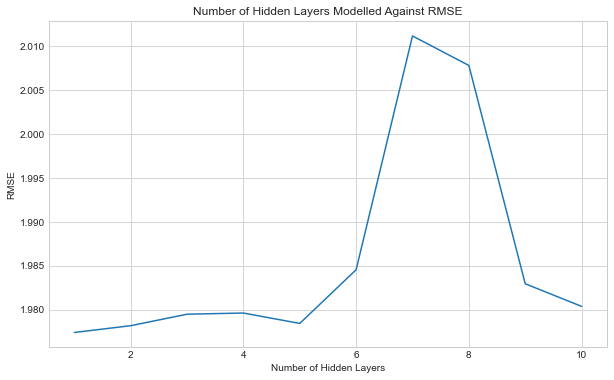

In [9]:
plt.style.use('seaborn-whitegrid')
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x=layers,y=rmselist)
ax.set(xlabel='Number of Hidden Layers',ylabel='RMSE',title='Number of Hidden Layers Modelled Against RMSE')
plt.xticks(rotation=0)

In [7]:
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}


x_trainshape = 5844

class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=160,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 160)
        self.output = nn.Linear(160, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()

net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print('RMSE:', rmse)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.2382        4.2261  93.2467
      2        4.1492        4.0793  95.5104
      3        4.0523        4.0422  95.9430
      4        4.0051        4.0720  98.3575
      5        3.9739        4.0326  96.3945
      6        3.9540        4.0121  98.9349
      7        3.9374        3.9960  98.0438
      8        3.9236        3.9835  98.5463
      9        3.9089        3.9857  98.8580
     10        3.8952        3.9624  99.3105
     11        3.8821        3.9625  99.2466
     12        3.8675        3.9409  100.0867
     13        3.8544        3.9264  100.7181
     14        3.8397        3.9169  101.2855
     15        3.8263        3.9118  102.3604
     16        3.8143        3.9025  102.3344
     17        3.7999        3.9036  102.8189
     18        3.7870        3.9020  104.0407
     19        3.7741        3.9032  107.9427
     20        3.7598        3.9031  105.8241
R

In [18]:
correct = 0
for i, (real, pred) in enumerate(zip(y_test, y_pred)):
    if real > 0 and pred > 0:
        correct += 1
    if real < 0 and pred < 0:
        correct += 1
print(correct/(len(y_test)))

0.5671359839428555


In [8]:
modelpreds = y_pred
y = y_test
z = y_testdates
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
for uni in unique:
    predsum = 0
    reala = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            reala = real
    invested += abs(predsum)
    daychange = predsum * reala
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [34268.26]
Accuracy: 0.6904761904761905
Sum Invested: [16657.725]
Profitability: [2.0571995]


In [5]:
print(len(unique))

252


In [7]:
profit = 0           
for i, (real, pred) in enumerate(zip(y_test, y_pred)):
    realmean = y_test.mean()
    predmean = y_pred.mean()
    realchange = real - realmean
    predchange = pred - predmean
    change = (predchange * realchange)
    change = pred - real
    profit += change
print(profit)

[33723.45]


In [ ]:
dftest = pd.DataFrame(y_test)
dftest['index'] = list(range(103427))
dfpred = pd.DataFrame(y_pred)
dfpred['index'] = list(range(103427))
fix, ax = plt.subplots()
sns.kdeplot(x=dftest['index'],y=dftest[0], cumulative=True, color='orange', label='real')
sns.kdeplot(x=dfpred['index'],y=dfpred[0], cumulative=True, color='b', label='pred')

plt.show()

In [ ]:

from sklearn.ensemble import RandomForestRegressor
text_classifier = RandomForestRegressor(n_estimators=100, random_state=0)  
text_classifier.fit(x_train, y_train)


predictions = text_classifier.predict(x_test)
 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

In [73]:
cross_val_score.get_params()

AttributeError: 'function' object has no attribute 'get_params'

In [8]:
y = merged['Change']

X = processed_tweets

data = pd.DataFrame()
data['text'] = processed_tweets
data['y'] = y.tolist()


from sklearn.model_selection import train_test_split  
data1 = data.sample(frac=0.2)
X1 = data1['text'].tolist()
y2 = np.array(data1['y'])
x_trainsvm, x_testsvm, y_trainsvm, y_testsvm = train_test_split(X1, y2, test_size=0.2, random_state=0)


In [9]:
from sklearn.svm import LinearSVR, SVR

def identity_tokenizer(text):
    return text


# y_trainsvm = np.array(y_train).ravel()
# y_testsvm = np.array(y_test).ravel()

#Create the SVM model

start = time.time()
# regressor = LinearSVR(random_state = 0)
regressor = SVR()
#Fit the model for the data
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True, stop_words="english",token_pattern=r'[^\s]+')), ("regressor", regressor)])

pipe.fit(x_trainsvm, y_trainsvm)

#Make the prediction
y_predsvm = pipe.predict(x_testsvm)

end = time.time()
print("Elapsed Time: ", (end-start),"\n")

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Elapsed Time:  1705.32363986969 



In [11]:
rmse = mean_squared_error(y_testsvm, y_predsvm, squared = False)
print("RMSE:",rmse)
r2 = r2_score(y_testsvm,y_predsvm)
print("R-Squared:",r2)

RMSE: 1.977553460848178
R-Squared: 0.0333595799537606


In [ ]:
accuracies = cross_val_score(estimator = regressor, X = x_trainsvm, y = y_trainsvm, cv = 10)
end = time.time()
# print("Fraction: ", x)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
mse = mean_squared_error(y_test,y_predsvm)
print("Mean Squared Error: {}".format(mse))
r2 = r2_score(y_test,y_predsvm)
print("R-squared: {}".format(r2))
print("")
print("Elapsed Time: ", (end-start),"\n")

D:\Documents\anaconda3\envs\DataSciEnv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [31]:
mse = mean_squared_error(y_test,y_predsvm)
print("Mean Squared Error: {}".format(mse))
r2 = r2_score(y_test,y_predsvm)
print("R-squared: {}".format(r2))

4.00098072231255
Mean Squared Error: 4.00098072231255
R-squared: 0.025518011281076225
